## Reproduction on ImageNet-10

## Setup: Model Imports and Configuration
Imports custom model architectures and defines the dataset path and configuration variables for activation functions and model choices.


In [1]:
import os
import time
from model.ResNet18 import ResNet18
from model.CustomCNN import CustomCNN
from model.MobileNetV2 import MobileNetV2
from model.DenseNet121 import DenseNet121

imagenet100_path = "data/imagenet-1300-10"
# imagenet100_path = "data/imagenet-100-imagefolder"

ACTIVATIONS = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable']
MODELS = ['ResNet18', 'CustomCNN', 'MobileNetV2']

## Setup: PyTorch and TorchVision Utilities
Here we import essential PyTorch and TorchVision modules for model training, optimization, and dataset loading. We also configure the device for training (GPU or CPU).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import densenet121, wide_resnet50_2
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from tqdm import tqdm
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preparation: ImageNet-10 (Subset of ImageNet-100)
Defines data transforms and loads the ImageNet-10 dataset using `torchvision.datasets.ImageFolder`. Both training and validation sets are processed using standard normalization and resizing/cropping techniques.


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

train_dataset = datasets.ImageFolder(f"{imagenet100_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{imagenet100_path}/val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)


## Activation Functions
This cell defines custom Swish activation functions:
- `SwishFixed`: uses a fixed β = 1
- `SwishTrainable`: learns β during training via backpropagation

An `activation_map` dictionary is constructed to map string names to instantiated activation modules, enabling dynamic activation injection.

In [4]:
# Define Activation Functions
class SwishFixed(nn.Module):
    def forward(self, x): return x * torch.sigmoid(x)

class SwishTrainable(nn.Module):
    def __init__(self):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, x): return x * torch.sigmoid(self.beta * x)

activation_map = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(0.1),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ELU': nn.ELU(),
    'Swish_fixed': SwishFixed(),
    'Swish_trainable': SwishTrainable()
}

# for name, act in activation_map.items():
#     print(f"{name}: {act}, type: {type(act)}, is nn.Module? {isinstance(act, nn.Module)}")


## Validation Function

Defines `validate()`, a utility function to evaluate model performance on a given validation set. It returns:
- Average loss
- Top-1 accuracy
- Top-5 accuracy

In [5]:
def validate(model, loader, criterion):
    model.eval(); total_loss=top1=top5=total=0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)

            _, pred = out.topk(5, dim=1)
            correct = pred.eq(y.view(-1, 1).expand_as(pred))
            top1 += correct[:, 0].sum().item()
            top5 += correct.sum().item()
            total += y.size(0)

    return total_loss / total, 100. * top1 / total, 100. * top5 / total


## Training Loop

Defines the main training loop that performs forward and backward passes, updates model weights, and tracks metrics such as loss and accuracy across epochs.


In [ ]:
import torchvision.models as models
import torch.nn as nn

SELECT_MODEL = 'ResNet18'         # options: ResNet18, MobileNetV2
SELECT_ACTIVATION = 'Swish_fixed'  # 'ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable'
activation_fn = activation_map[SELECT_ACTIVATION]

num_classes = 10  # or 100 for ImageNet-100


## Training Pipeline: Model Initialization, Optimization, and Logging

This section performs the complete training routine for a selected model-activation combination on the ImageNet-10 dataset. The key components are as follows:

### Model Construction
The model is dynamically initialized from one of the following architectures:
- `ResNet18`, `MobileNetV2`

Each model receives the activation function specified by `SELECT_ACTIVATION`, injected via the `activation_map`. The number of output classes is fixed at 10.

### Optimization and Scheduling
- **Loss Function**: CrossEntropyLoss
- **Optimizer**: Stochastic Gradient Descent (SGD) with momentum, weight decay, and Nesterov acceleration
- **Scheduler**: CosineAnnealingLR to adjust learning rate over 200 iterations

### Training History Tracking
The script records training and validation metrics in the `history` dictionary:
- `train_loss`, `train_acc`: Training loss and accuracy per epoch
- `val_loss`, `val_acc`, `val_top5`: Validation loss, Top-1 and Top-5 accuracy per epoch
- `epoch_time`: Time duration of each epoch
- `max_gpu_mem`: Peak GPU memory usage in megabytes

### Checkpointing and Resume Logic
- If a previous checkpoint exists for the model-activation pair (`resume_*.pt`), training resumes from the last saved epoch.
- After each epoch, model weights, optimizer/scheduler state, and full history are saved for resumption and reproducibility.

### Validation
Validation is performed at the end of each epoch using the `validate()` function. Top-1 and Top-5 accuracies are printed and logged.

### Output Artifacts
At the end of training:
- The final trained model is saved as `ImageNet100_<MODEL>_<ACTIVATION>.pth` under `model/<activation>/`
- The complete training history is saved as `history_<MODEL>_<ACTIVATION>.pt` under `checkpoints/<activation>/`

This structure supports fair comparison of activation functions and facilitates later evaluation, visualization, and performance analysis.


In [ ]:
model = {
    'ResNet18': ResNet18(activation=activation_map[SELECT_ACTIVATION], num_classes=10),
    'CustomCNN': CustomCNN(activation=activation_map[SELECT_ACTIVATION], num_classes=10),
    'MobileNetV2': MobileNetV2(activation=activation_map[SELECT_ACTIVATION], num_classes=10)
}[SELECT_MODEL].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

NUM_EPOCHS = 20

hist_dir = os.path.join("checkpoints", SELECT_ACTIVATION)
os.makedirs(hist_dir, exist_ok=True)
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5': [],
    'epoch_time': [],     # Track epoch duration (in seconds)
    'max_gpu_mem': []     # Track max GPU memory (in MB)
}

resume_path = os.path.join(hist_dir, f"resume_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt")
start_epoch = 1

if os.path.exists(resume_path):
    print(f"Resuming training from {resume_path}")
    checkpoint = torch.load(resume_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    history = checkpoint['history']
    start_epoch = checkpoint['epoch'] + 1

for epoch in range(start_epoch, NUM_EPOCHS+1):
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()  # Reset tracking
    
    model.train(); running_loss=correct=total=0; start=time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", unit='batch')
    for x,y in pbar:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(); out = model(x); loss = criterion(out,y)
        loss.backward(); optimizer.step()
        bs = x.size(0); running_loss+=loss.item()*bs; preds=out.argmax(1)
        correct+=preds.eq(y).sum().item(); total+=bs
        elapsed = time.time()-start; rem=elapsed*(len(train_loader)-pbar.n)
        m, s = divmod(int(rem),60)
        pbar.set_postfix({'loss':f"{running_loss/total:.4f}",'acc':f"{100.*correct/total:.2f}%",'ETA':f"{m}m{s}s"})
    scheduler.step()
    
    epoch_time = time.time() - start_time
    max_mem_mb = torch.cuda.max_memory_allocated() / 1024 / 1024
    
    val_loss, val_top1, val_top5 = validate(model, val_loader, criterion)

    history['train_loss'].append(running_loss / total)
    history['train_acc'].append(100. * correct / total)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_top1)
    history.setdefault('val_top5', []).append(val_top5)
    history['epoch_time'].append(epoch_time)
    history['max_gpu_mem'].append(max_mem_mb)

    print(f"Epoch {epoch}/{NUM_EPOCHS} Train Acc: {100.*correct/total:.2f}% | "
          f"Val Top-1 Acc: {val_top1:.2f}% | Val Top-5 Acc: {val_top5:.2f}%")
    
    # Save checkpoint for resume
    resume_state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history,
        'epoch': epoch
    }
    torch.save(resume_state, os.path.join(hist_dir, f"resume_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt"))


# Save Model

save_dir = os.path.join("model", SELECT_ACTIVATION)
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"ImageNet100_{SELECT_MODEL}_{SELECT_ACTIVATION}.pth")
torch.save(model.state_dict(), save_path)

# save history

hist_path = os.path.join(hist_dir, f"history_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt")
torch.save(history, hist_path)

print("Saved history to", hist_path)

## Accuracy Visualization

Plots the validation (test) accuracy over epochs for a specific model-activation pair. This helps assess convergence behavior and final model performance.


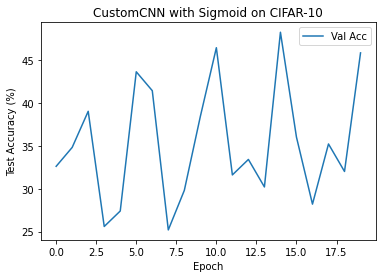

In [8]:
import matplotlib.pyplot as plt
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Test Accuracy (%)')
plt.title(f'{SELECT_MODEL} with {SELECT_ACTIVATION} on CIFAR-10')
plt.legend(); plt.show()


## Cross-Activation Accuracy Comparison

This section visualizes the validation accuracy curves for all activation functions on a selected model (e.g., ResNet18, MobileNetV2, or CustomCNN).

- Loads saved training history (`.pt` files) from a structured `checkpoints/` directory.
- For each activation function, retrieves the validation accuracy and plots it over training epochs.
- Skips activations with missing or malformed logs.
- The final plot highlights the convergence behavior and comparative performance across activations for the chosen architecture.

> ⚠️ Ensure that the `checkpoints/` directory contains subfolders named by activation (e.g., `ReLU/`, `Swish_fixed/`) and valid `history_*.pt` files.


Missing: checkpoints/Tanh/history_CustomCNN_Tanh.pt
Missing: checkpoints/ELU/history_CustomCNN_ELU.pt
Missing: checkpoints/Swish_fixed/history_CustomCNN_Swish_fixed.pt
Missing: checkpoints/Swish_trainable/history_CustomCNN_Swish_trainable.pt


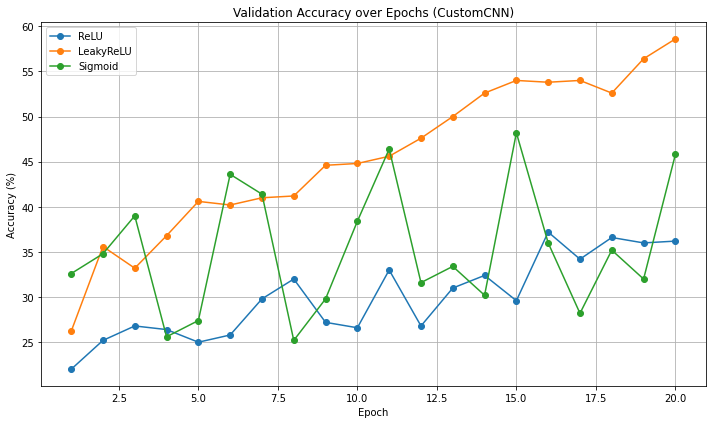

In [9]:
import os
import torch
import matplotlib.pyplot as plt

BASE_DIR = "checkpoints"  # or wherever your .pt files are saved
SELECT_MODEL = "CustomCNN"  # or "ResNet18", "MobileNetV2", "CustomCNN" etc.

# List all activations you used in training
ACTIVATIONS = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable']

plt.figure(figsize=(10,6))

for activation in ACTIVATIONS:
    hist_path = os.path.join(BASE_DIR, activation, f"history_{SELECT_MODEL}_{activation}.pt")
    if not os.path.exists(hist_path):
        print(f"Missing: {hist_path}")
        continue

    history = torch.load(hist_path)
    acc_list = history.get('val_acc', history.get('val_acc', []))
    max_gpu_list = history.get('max_gpu_mem', history.get('max_gpu_mem', []))
    
    if not acc_list:
        print(f"No val/test acc found in {activation}")
        continue

    epochs = range(1, len( acc_list) + 1)
    plt.plot(epochs,  acc_list, marker='o', label=activation)

plt.title(f"Validation Accuracy over Epochs ({SELECT_MODEL})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{SELECT_MODEL}_val_acc_plot.png", dpi=300)

plt.show()
# plt.savefig(f"{SELECT_MODEL}_val_acc_plot.png", dpi=300)
